# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
%matplotlib inline 
#  !pip3 install mpld3
import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys

In [3]:
from Cluster import * 

Getting data:
getting JHU data...
number of countries listed 274
done with JHU data (covid_ts dictionary keys: confirmed, deaths, recovered).  Got  274 countries (countries_jhu).
getting owid data...
data for population changes only slowly if at all in OWID database
data for population density changes only slowly if at all in OWID database
data for gdp per capita changes only slowly if at all in OWID database
done with owid data (covid_owid_ts dictionary see .keys()) . Got 212 countries (countries_owid)
WHO acute file found dictionary acute_who
ICU file found dictionary icus_2012
---------------------------------
Done with data.
---------------------------------
Getting deaths, case and testing data...
done.
doing piecwise linear fits to testing data ...
done.
making cases with nonlinear testing adjustment...
done.
to change the nonlinear correction function, call make_cases_adj_nonlin(K), K=2 by default
----------------------------------------
Finished loading Cluster module
---------

In [4]:
from model_fits import *  # including ModelFit class definition.

loading data.py...
done with data.py.
making the models...
SEI3R
SC3EI3R
SC3UEI3R
done with the models.


In [37]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in countries if population_owid[cc][0] > 0]
print(len(countries),'countries with population data')


53 countries with population data


# Curve Fitting Example

We want to fit the following curve:

In [18]:
def exponential_growth(x,A,k):
    return A*np.exp(x*k)

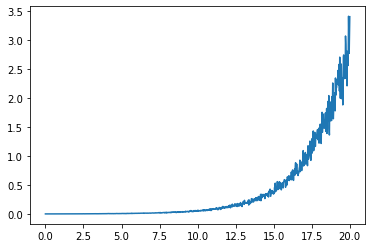

In [19]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (exponential_growth(x, 0.001, 0.4) * (1.0 + np.random.normal(scale=0.1, size=x.size)))  # exponential distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [4]:
def f(x, a, b):
    return exponential_growth(x, a, b) 

In [5]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=0.02, vary=True)
mod.set_param_hint("b", value=0.5, vary=True)

params = mod.make_params()

In [6]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 0.0011015708523488322, 'b': 0.3951473987912008}

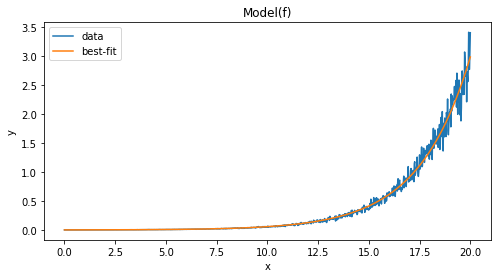

In [7]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [8]:
result

# Use ModelFit class

In [726]:
#  file containing only ModelFit class, 
#exec(open('ModelFit.py','r').read())

In [5]:
testfit = ModelFit('SC3EI3R',country='Germany',run_id="_tst")

============= SC3EI3R_Germany_tst
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_tst.pk :


In [6]:
foo = testfit.solvefit()

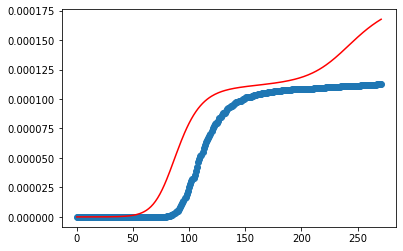

In [7]:
dat = foo['deaths']['data']
plt.plot(range(len(dat)),dat,'o')
plt.plot(foo['deaths']['soln'],color='red');

# Use `Modelfit.solvefit()` with `lmfit`

In [44]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
#exec(open('ModelFit.py','r').read())

In [5]:
gamma = 1.0/9.0
sigma = 1.0/3.0
country = 'Germany'
fit_target = 'deaths'
MyModel = ModelFit('SC3EI3R',country=country,run_id="_fitter_"+country+'_'+fit_target)
fitdata = MyModel.get_fitdata(fit_target)[fit_target]

def resid(params_lmf):
    MyModel.set_param('beta_1', params_lmf['beta_1'].value)
    MyModel.set_param('mu', params_lmf['mu'].value)
    MyModel.set_param('c_0', params_lmf['c_0'].value)
    MyModel.set_param('c_1', params_lmf['c_1'].value)
    MyModel.set_param('c_2', params_lmf['c_2'].value)
    MyModel.set_I0(params_lmf['logI_0'].value)
    fittry = MyModel.solvefit(fit_target)
    return fittry[fit_target]['resid']



============= SC3EI3R_Germany_fitter_Germany_deaths
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_fitter_Germany_deaths.pk :


In [6]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0), 
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000), 
                        "logI_0": (-6.,-10.,0.0)}

In [7]:
params_lmf = lmfit.Parameters()
for pp in params_init_min_max:
    params_lmf.add(pp,params_init_min_max[pp][0],min=params_init_min_max[pp][1],max=params_init_min_max[pp][2])

In [8]:
params_lmf

name,value,initial value,min,max,vary
beta_1,0.20000000,0.2,0.00000000,2.00000000,True
mu,0.10000000,0.1,0.00000000,0.20000000,True
c_0,0.10000000,0.1,0.00000000,1.00000000,True
c_1,0.07000000,0.07,0.00000000,0.50000000,True
c_2,5000.00000,5000,0.00000000,20000.0000,True
logI_0,-6.00000000,-6.0,-10.0000000,0.00000000,True


In [9]:
# to view intermediate results with a callback function

residall = []
paramsall = []
def per_iteration(pars, iteration, resid, *args, **kws):
    #print(" ITER ", iteration, ["%.5f" % p for p in pars.values()])
    res2 = np.array([x*x for x in resid])
    sumres2 = np.sqrt(np.sum(res2))
    #print(" ITER ", iteration, " sum res^2 = ",sumres2)
    residall.append(sumres2)
    paramsall.append(pars.copy())


In [10]:
start = time()
x = list(range(len(fitdata)))
outfit = lmfit.minimize(resid, params_lmf, method='nelder',iter_cb=per_iteration)
print('elapsed =',time()-start)

elapsed = 45.103801012039185


In [11]:
lmfit.report_fit(outfit)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1881
    # data points      = 272
    # variables        = 6
    chi-square         = 6.2975e-11
    reduced chi-square = 2.3675e-13
    Akaike info crit   = -7901.59238
    Bayesian info crit = -7879.95757
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.53145986 +/-        nan (nan%) (init = 0.2)
    mu:      0.09870022 +/- 3.4239e-06 (0.00%) (init = 0.1)
    c_0:     0.22887063 +/-        nan (nan%) (init = 0.1)
    c_1:     0.00430291 +/- 1.3447e-06 (0.03%) (init = 0.07)
    c_2:     13012.0040 +/- 0.33518654 (0.00%) (init = 5000)
    logI_0: -9.78456703 +/-        nan (nan%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, c_1)  = -3.149
    C(c_1, c_2) =  3.143
    C(mu, c_2)  =  2.490


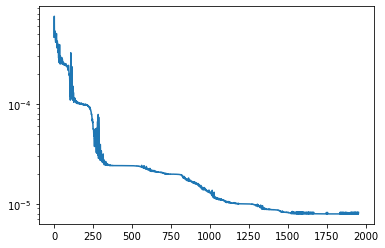

In [12]:
#plt.plot(residall);
plt.semilogy(residall);


In [13]:
pars = [x for x in paramsall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

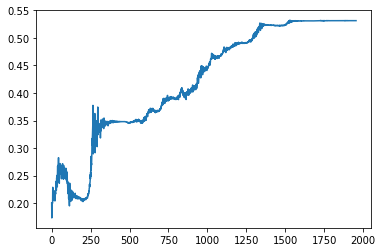

In [14]:
p0 = [x[pars[0]] for x in paramsall]
plt.plot(p0);

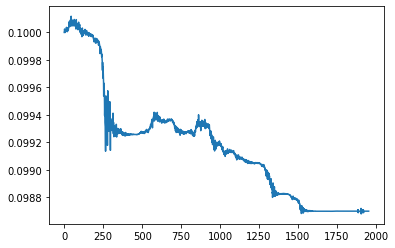

In [15]:
p0 = [x[pars[1]] for x in paramsall]
plt.plot(p0);

In [16]:
outfit.params

name,value,standard error,relative error,initial value,min,max,vary
beta_1,0.53145986,nan,(nan%),0.2,0.00000000,2.00000000,True
mu,0.09870022,3.4239e-06,(0.00%),0.1,0.00000000,0.20000000,True
c_0,0.22887063,nan,(nan%),0.1,0.00000000,1.00000000,True
c_1,0.00430291,1.3447e-06,(0.03%),0.07,0.00000000,0.50000000,True
c_2,13012.0040,0.33518654,(0.00%),5000,0.00000000,20000.0000,True
logI_0,-9.78456703,nan,(nan%),-6.0,-10.0000000,0.00000000,True


In [17]:
for x in outfit.params:
    if x in MyModel.params:
        MyModel.set_param(x, outfit.params[x].value)
MyModel.set_I0(outfit.params['logI_0'].value)


In [18]:
MyModel.params

{'beta_1': 0.5314598601975564,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334,
 'mu': 0.09870022131270663,
 'c_0': 0.22887062679637077,
 'c_1': 0.0043029070498890876,
 'c_2': 13012.003968718693,
 'N': 1}

fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_fitter_Germany_deaths.pk


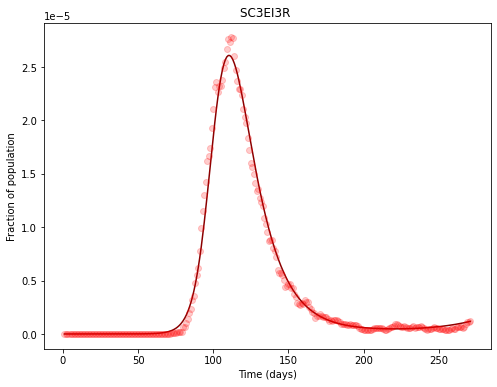

In [19]:
MyModel.solveplot(species=['deaths'])

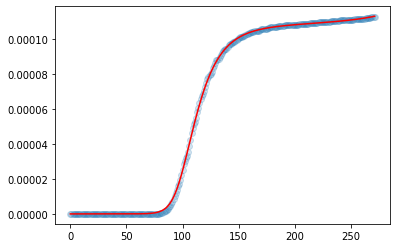

In [20]:
foo = MyModel.solvefit('deaths')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

## Trying different fitting methods...

see [lmfit documentation](https://lmfit.github.io/lmfit-py/fitting.html) on fitting methods for the list.

In this section I am using the same basic template to repeat the basic fitting operation with different fitting methods.

All seem to work.  Some comments:
* some (e.g. leastsq, differential_evolution) seem to hop all over the place, giving wildly varying residual socre and param convergence.
* some (powell, cobyla)seem to converge fast at beginning, with a slow tail (view residual plot with semilog)
* chose nelder, because of consistent gradual convergence.

## USA

In [6]:
gamma = 1.0/9.0
sigma = 1.0/3.0
country = 'United States'
fit_target = 'deaths'
MyModel = ModelFit('SC3EI3R',country=country,run_id="_fitter_"+country+'_'+fit_target)
fitdata = MyModel.get_fitdata(fit_target)[fit_target]

def resid(params_lmf):
    MyModel.set_param('beta_1', params_lmf['beta_1'].value)
    MyModel.set_param('mu', params_lmf['mu'].value)
    MyModel.set_param('c_0', params_lmf['c_0'].value)
    MyModel.set_param('c_1', params_lmf['c_1'].value)
    MyModel.set_param('c_2', params_lmf['c_2'].value)
    MyModel.set_I0(params_lmf['logI_0'].value)
    fittry = MyModel.solvefit(fit_target)
    return fittry[fit_target]['resid']



============= SC3EI3R_United States_fitter_United States_deaths
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_fitter_United States_deaths.pk :


In [7]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0), 
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000), 
                        "logI_0": (-6.,-10.,0.0)}

In [8]:
params_lmf = lmfit.Parameters()
for pp in params_init_min_max:
    params_lmf.add(pp,params_init_min_max[pp][0],min=params_init_min_max[pp][1],max=params_init_min_max[pp][2])

In [9]:
params_lmf

name,value,initial value,min,max,vary
beta_1,0.20000000,0.2,0.00000000,2.00000000,True
mu,0.10000000,0.1,0.00000000,0.20000000,True
c_0,0.10000000,0.1,0.00000000,1.00000000,True
c_1,0.07000000,0.07,0.00000000,0.50000000,True
c_2,5000.00000,5000,0.00000000,20000.0000,True
logI_0,-6.00000000,-6.0,-10.0000000,0.00000000,True


In [10]:
# to view intermediate results with a callback function

residall = []
paramsall = []
def per_iteration(pars, iteration, resid, *args, **kws):
    #print(" ITER ", iteration, ["%.5f" % p for p in pars.values()])
    res2 = np.array([x*x for x in resid])
    sumres2 = np.sqrt(np.sum(res2))
    #print(" ITER ", iteration, " sum res^2 = ",sumres2)
    residall.append(sumres2)
    paramsall.append(pars.copy())


In [11]:
start = time()
x = list(range(len(fitdata)))
outfit = lmfit.minimize(resid, params_lmf, method='nelder',iter_cb=per_iteration)
print('elapsed =',time()-start)

elapsed = 31.28975510597229


In [12]:
lmfit.report_fit(outfit)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1292
    # data points      = 272
    # variables        = 6
    chi-square         = 2.3283e-09
    reduced chi-square = 8.7530e-12
    Akaike info crit   = -6919.62888
    Bayesian info crit = -6897.99407
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.48265356 +/-        nan (nan%) (init = 0.2)
    mu:      0.10117959 +/- 3.3954e-04 (0.34%) (init = 0.1)
    c_0:     0.22421236 +/- 0.00124169 (0.55%) (init = 0.1)
    c_1:     0.05347697 +/- 4.1789e-04 (0.78%) (init = 0.07)
    c_2:     5412.06342 +/-        nan (nan%) (init = 5000)
    logI_0: -9.06160942 +/-        nan (nan%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, c_0)  =  1.706
    C(mu, c_1)  = -1.100
    C(c_0, c_1) = -0.646


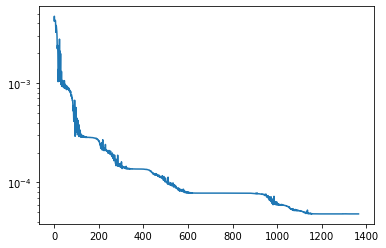

In [13]:
#plt.plot(residall);
plt.semilogy(residall);


In [21]:
pars = [x for x in paramsall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

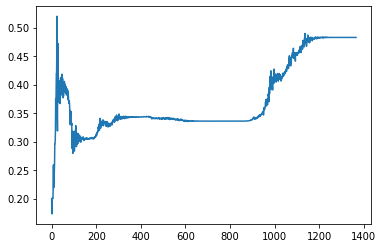

In [16]:
p0 = [x[pars[0]] for x in paramsall]
plt.plot(p0);

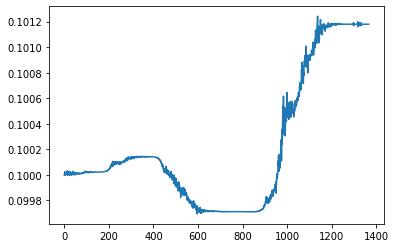

In [17]:
p0 = [x[pars[1]] for x in paramsall]
plt.plot(p0);

In [18]:
outfit.params

name,value,standard error,relative error,initial value,min,max,vary
beta_1,0.48265356,nan,(nan%),0.2,0.00000000,2.00000000,True
mu,0.10117959,3.3954e-04,(0.34%),0.1,0.00000000,0.20000000,True
c_0,0.22421236,0.00124169,(0.55%),0.1,0.00000000,1.00000000,True
c_1,0.05347697,4.1789e-04,(0.78%),0.07,0.00000000,0.50000000,True
c_2,5412.06342,nan,(nan%),5000,0.00000000,20000.0000,True
logI_0,-9.06160942,nan,(nan%),-6.0,-10.0000000,0.00000000,True


In [19]:
for x in outfit.params:
    if x in MyModel.params:
        MyModel.set_param(x, outfit.params[x].value)
MyModel.set_I0(outfit.params['logI_0'].value)


In [20]:
MyModel.params

{'beta_1': 0.48265356409811566,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334,
 'mu': 0.10117958805908887,
 'c_0': 0.22421235684354263,
 'c_1': 0.05347696937586893,
 'c_2': 5412.063420835358,
 'N': 1}

fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_fitter_United States_deaths.pk


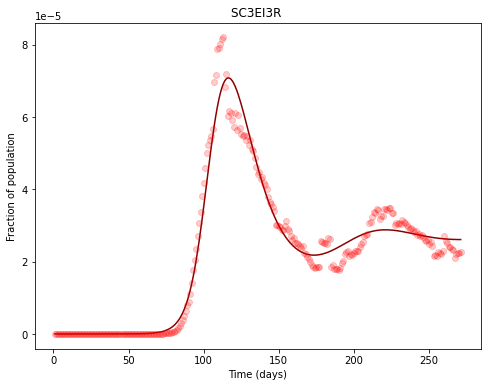

In [21]:
MyModel.solveplot(species=['deaths'])

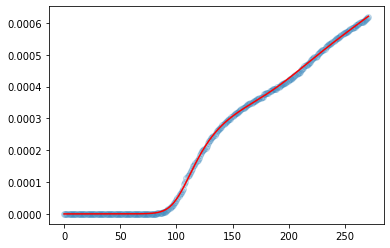

In [22]:
foo = MyModel.solvefit('deaths')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

# ModelFit + lmfit on lots of countries

In [4]:
len(countries)

114

In [5]:
def resid(params_lmf):
    MyModel.set_param('beta_1', params_lmf['beta_1'].value)
    MyModel.set_param('mu', params_lmf['mu'].value)
    MyModel.set_param('c_0', params_lmf['c_0'].value)
    MyModel.set_param('c_1', params_lmf['c_1'].value)
    MyModel.set_param('c_2', params_lmf['c_2'].value)
    MyModel.set_I0(params_lmf['logI_0'].value)
    fittry = MyModel.solvefit(fit_target)
    return fittry[fit_target]['resid']




In [54]:
country = 'Germany'
fit_target='deaths'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_fitter_"+fit_target)
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                   "mu": (.1,0.,.2),
                   "c_0": (0.1, 0., 1.0), 
                   "c_1": (0.07, 0.0, 0.5),
                   "c_2": (5000, 0.,20000), 
                    "logI_0": (-6.,-10.,0.0)}
params_lmf = lmfit.Parameters()
for pp in params_init_min_max:
    params_lmf.add(pp,params_init_min_max[pp][0],min=params_init_min_max[pp][1],max=params_init_min_max[pp][2])

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_fitter_deaths.pk :


In [60]:
[(p,params_lmf[p].value) for p in params_lmf]

[('beta_1', 0.2),
 ('mu', 0.1),
 ('c_0', 0.1),
 ('c_1', 0.07),
 ('c_2', 5000),
 ('logI_0', -6.0)]

fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_fitter_deaths.pk


Text(0.5, 1.0, 'Germany')

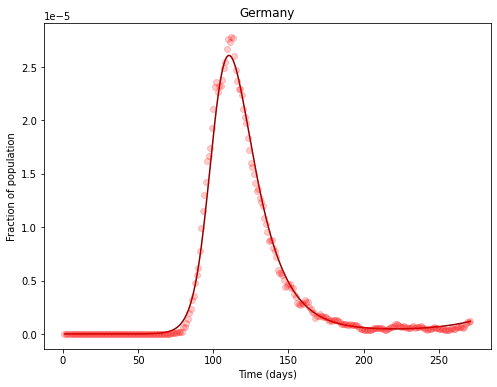

In [9]:
outfit = lmfit.minimize(resid, params_lmf, method='nelder')
# set model params to fitted values:
for x in outfit.params:
    if x in MyModel.params:
        MyModel.set_param(x, outfit.params[x].value)
MyModel.set_I0(outfit.params['logI_0'].value)
MyModel.solveplot(species=['deaths'])
plt.title(country)

============= SC3EI3R_Afghanistan_fitter_deaths
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Afghanistan_fitter_deaths.pk :
fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Afghanistan_fitter_deaths.pk
============= SC3EI3R_Algeria_fitter_deaths
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Algeria_fitter_deaths.pk :
fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Algeria_fitter_deaths.pk
============= SC3EI3R_Armenia_fitter_deaths
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Armenia_fitter_deaths.pk :
fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Armenia_fitter_deaths.pk
============= SC3EI3R_Australia_fitter_deaths
loaded params from  /Users/n/Project

fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Finland_fitter_deaths.pk
============= SC3EI3R_France_fitter_deaths
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_France_fitter_deaths.pk :
fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_France_fitter_deaths.pk
============= SC3EI3R_Germany_fitter_deaths
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_fitter_deaths.pk :
fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_fitter_deaths.pk
============= SC3EI3R_Greece_fitter_deaths
no file available with this run_id:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Greece_fitter_deaths.pk
Problem loading paramfile for _fitter_deaths ... using default set of parameters for

fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Mexico_fitter_deaths.pk
============= SC3EI3R_Nepal_fitter_deaths
no file available with this run_id:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Nepal_fitter_deaths.pk
Problem loading paramfile for _fitter_deaths ... using default set of parameters for model type SC3EI3R
fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Nepal_fitter_deaths.pk
============= SC3EI3R_Netherlands_fitter_deaths
no file available with this run_id:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Netherlands_fitter_deaths.pk
Problem loading paramfile for _fitter_deaths ... using default set of parameters for model type SC3EI3R
fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Netherlands_fitter_deaths.pk
============= SC3

fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United Kingdom_fitter_deaths.pk
============= SC3EI3R_United States_fitter_deaths
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_fitter_deaths.pk :
fit data  (272, 1)
dumped params to /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_fitter_deaths.pk


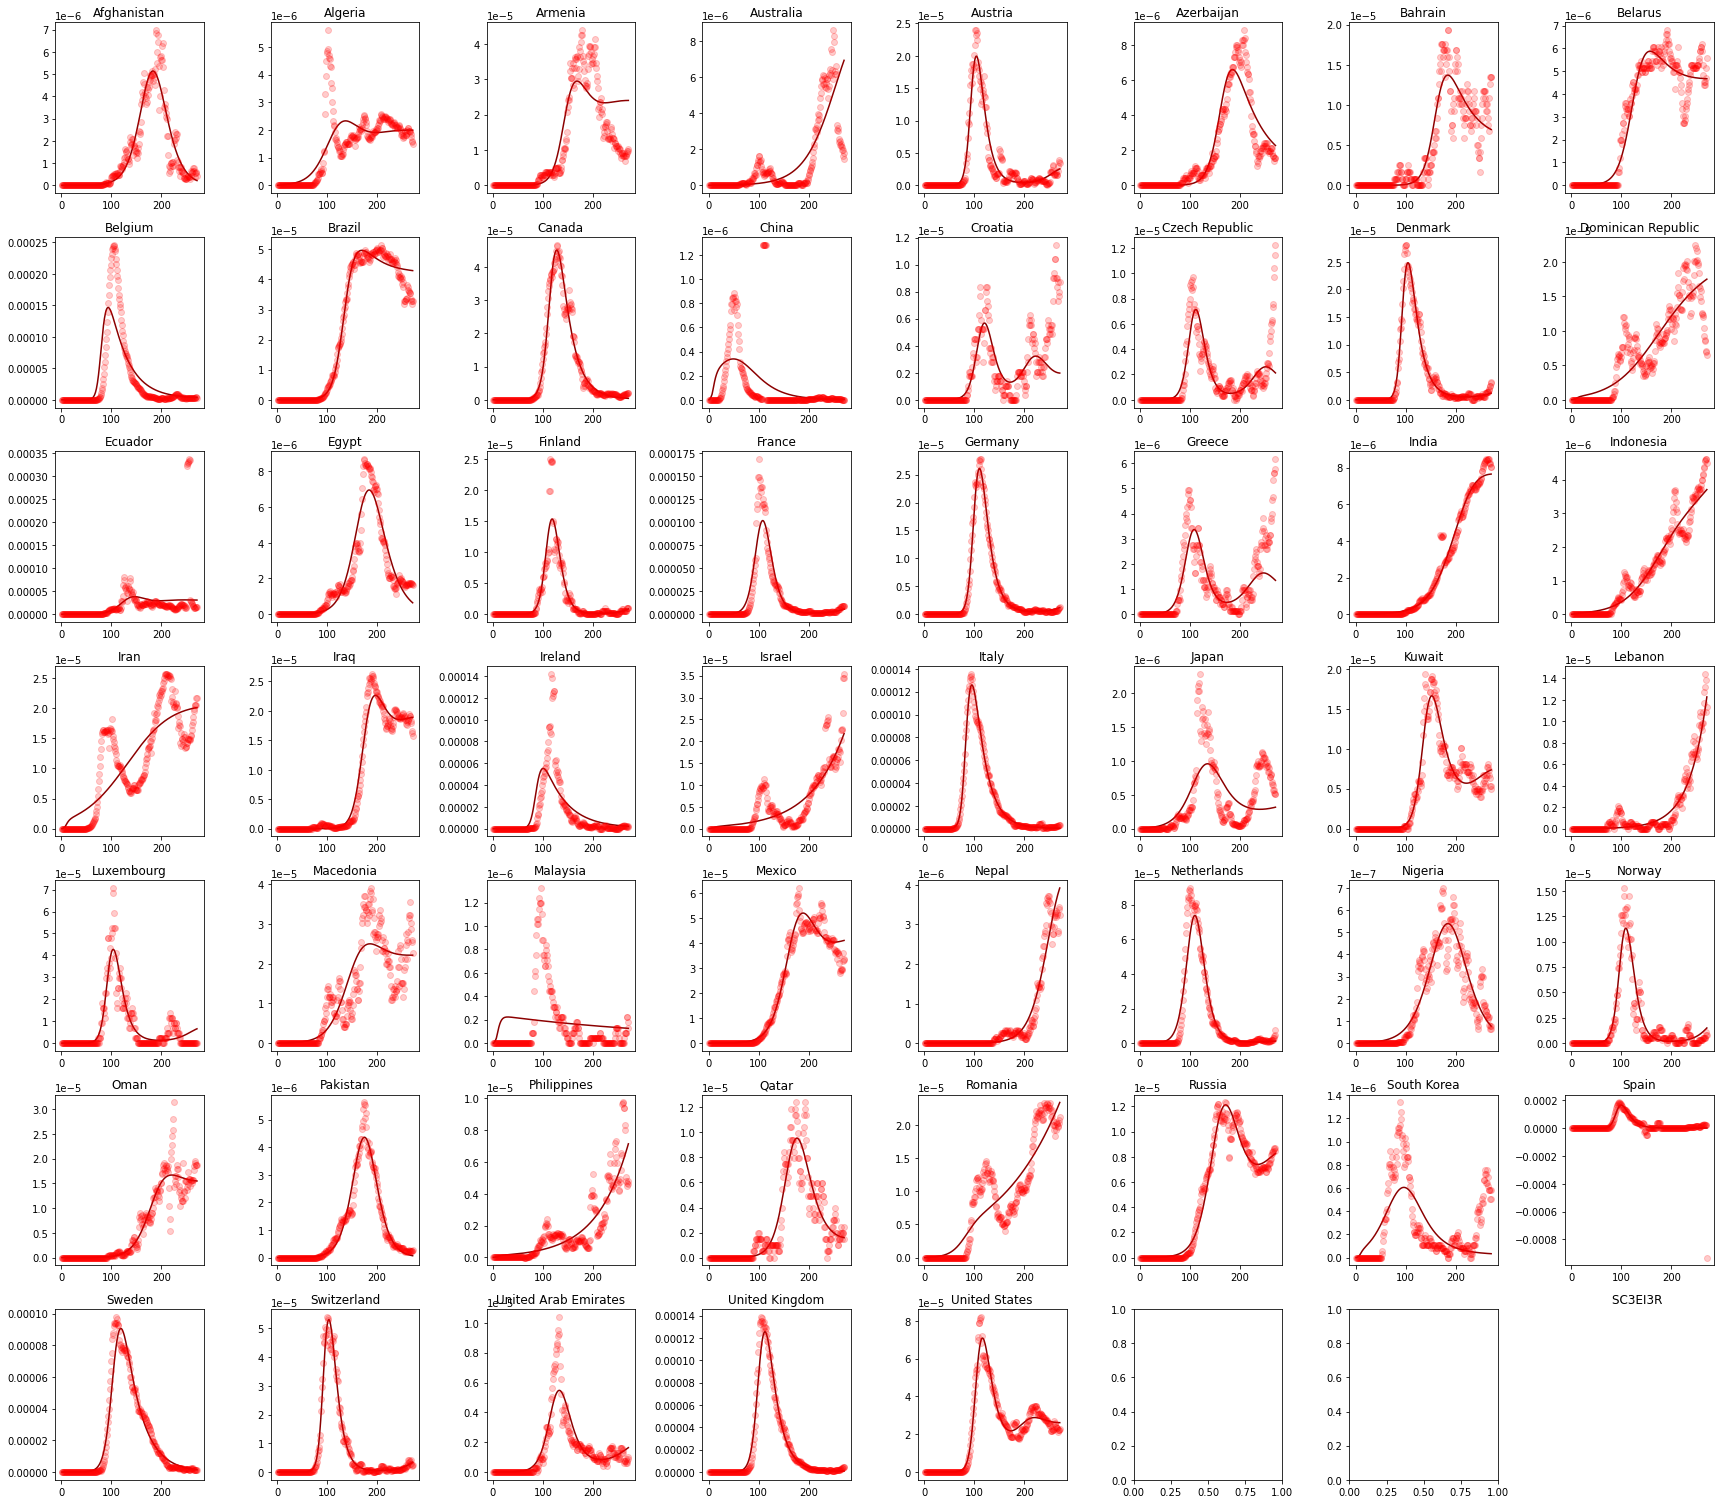

In [38]:
fit_target = 'deaths'
max_cols=8
max_rows=int(len(countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))

#for short test:
foocountries = [countries[i] for i in range(4)]+['Germany','United States','France','Spain']

cnt=0
for idx, country  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    MyModel = ModelFit('SC3EI3R',country=country,run_id="_fitter_"+fit_target)
    params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0), 
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000), 
                        "logI_0": (-6.,-10.,0.0)}
    params_lmf = lmfit.Parameters()
    for pp in params_init_min_max:
        params_lmf.add(pp,params_init_min_max[pp][0],min=params_init_min_max[pp][1],max=params_init_min_max[pp][2])
    try:
        outfit = lmfit.minimize(resid, params_lmf, method='nelder')
        # set model params to fitted values:
        for x in outfit.params:
            if x in MyModel.params:
                MyModel.set_param(x, outfit.params[x].value)
        MyModel.set_I0(outfit.params['logI_0'].value)
        MyModel.solveplot(species=['deaths'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt+2,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.show()


# ModelFit with lmfit integrated

In [197]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [151]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2")

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test2.pk :


In [152]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                   "mu": (.1,0.,.2),
                   "c_0": (0.1, 0., 1.0), 
                   "c_1": (0.07, 0.0, 0.5),
                   "c_2": (5000, 0.,20000), 
                    "logI_0": (-6.,-10.,0.0)}

In [153]:
MyModel.params

{'beta_1': 0.5314598601975564,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666666,
 'gamma_3': 0.10000000000000003,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333334,
 'mu': 0.09870022131270663,
 'c_0': 0.22887062679637077,
 'c_1': 0.0043029070498890876,
 'c_2': 13012.003968718693,
 'N': 1}

In [166]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder')

elapsed time =  28.046916007995605
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1881
    # data points      = 272
    # variables        = 6
    chi-square         = 6.2975e-11
    reduced chi-square = 2.3675e-13
    Akaike info crit   = -7901.59238
    Bayesian info crit = -7879.95757
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.53145986 +/-        nan (nan%) (init = 0.2)
    mu:      0.09870022 +/- 3.4239e-06 (0.00%) (init = 0.1)
    c_0:     0.22887063 +/-        nan (nan%) (init = 0.1)
    c_1:     0.00430291 +/- 1.3447e-06 (0.03%) (init = 0.07)
    c_2:     13012.0040 +/- 0.33518654 (0.00%) (init = 5000)
    logI_0: -9.78456703 +/-        nan (nan%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, c_1)  = -3.149
    C(c_1, c_2) =  3.143
    C(mu, c_2)  =  2.490


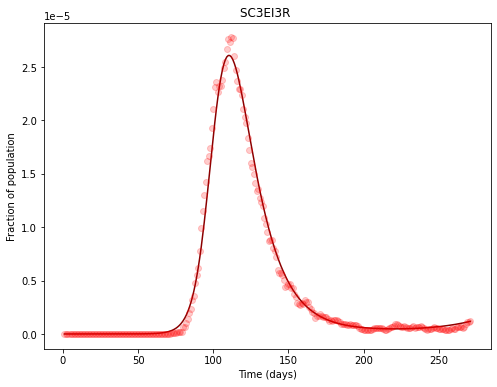

In [167]:
MyModel.solveplot('deaths')

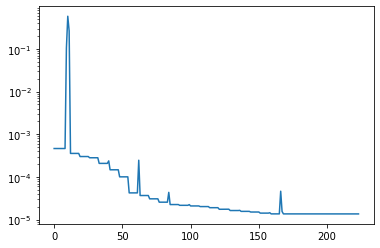

In [165]:
plt.semilogy(MyModel.residall);

## Try for U model class

From Caution_paper_Fitting notebook:
```    
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
```

In [168]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3UEI3R',country=country,run_id="_test")

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_United States_test.pk :


In [169]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}

In [170]:
for pp in params_init_min_max:
    if pp in MyModel.params:
        print(pp,MyModel.params[pp],params_init_min_max[pp])
    

beta_1 0.29 (0.2, 0.0, 2.0)
mu 0.10020082608068095 (0.1, 0.0, 0.2)
c_0 0.0660998825694582 (0.1, 0.0, 1.0)
c_1 0.036352803085880125 (0.07, 0.0, 0.5)
c_2 5613.480446603666 (5000, 0.0, 20000)
k_u 0.1873706480911983 (0.2, 0, 1)
k_1 0.0027054700168432366 (0.011111111111111112, 0.0, 1.0)
k_w 0.005333507965541995 (0.011111111111111112, 0.0, 1.0)


In [171]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max)

elapsed time =  27.693687200546265
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 675
    # data points      = 272
    # variables        = 9
    chi-square         = 8.5679e-08
    reduced chi-square = 3.2577e-10
    Akaike info crit   = -5932.94187
    Bayesian info crit = -5900.48965
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.29104292 (init = 0.2)
    mu:      0.10020083 (init = 0.1)
    c_0:     0.06609988 (init = 0.1)
    c_1:     0.03635280 (init = 0.07)
    c_2:     5613.48045 (init = 5000)
    k_u:     0.18737065 (init = 0.2)
    k_1:     0.00270547 (init = 0.01111111)
    k_w:     0.00533351 (init = 0.01111111)
    logI_0: -6.17497782 (init = -6)


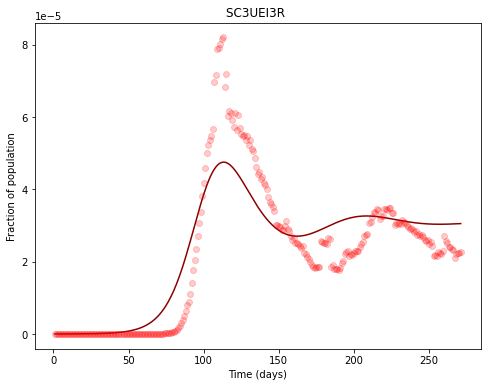

In [172]:
MyModel.solveplot('deaths')

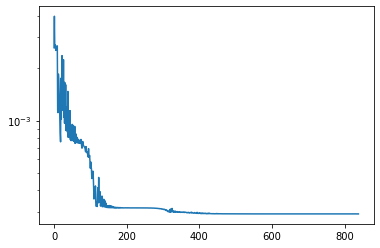

In [173]:
plt.semilogy(MyModel.residall);

In [174]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='leastsq')

elapsed time =  8.95629596710205
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 350
    # data points      = 272
    # variables        = 9
    chi-square         = 2.0165e-09
    reduced chi-square = 7.6672e-12
    Akaike info crit   = -6952.73893
    Bayesian info crit = -6920.28671
##  Warning: uncertainties could not be estimated:
    k_w:     at initial value
[[Variables]]
    beta_1:  0.43120580 (init = 0.2)
    mu:      0.05644585 (init = 0.1)
    c_0:     0.10620367 (init = 0.1)
    c_1:     8.3198e-04 (init = 0.07)
    c_2:     4868.54503 (init = 5000)
    k_u:     0.25740638 (init = 0.2)
    k_1:     0.00476825 (init = 0.01111111)
    k_w:     0.01111111 (init = 0.01111111)
    logI_0: -8.21463436 (init = -6)


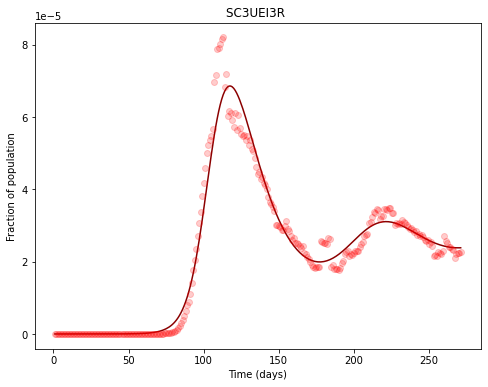

In [175]:
MyModel.solveplot('deaths')

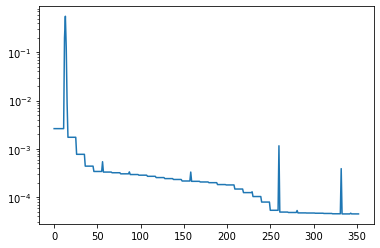

In [176]:
plt.semilogy(MyModel.residall);

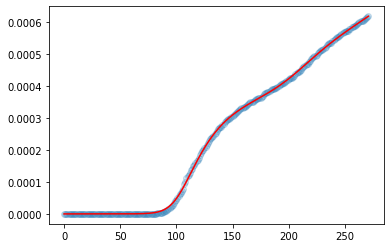

In [177]:
foo = MyModel.solvefit('deaths')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

### slider plot

In [131]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [132]:
def slidefitplot(beta_1):
    MyModel.set_param('beta_1',beta_1)
    MyModel.solveplot(species=['deaths'],figsize = (15,15))

In [134]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=MyModel.params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f')
             )
display(w)

interactive(children=(FloatSlider(value=0.29104292482815264, continuous_update=False, description='beta_1', la…

In [ ]:
def slidefitplot(beta_1,alpha,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta_1':beta_1, 'alpha':alpha, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

In [ ]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [148]:
def foo(**kwargs):
    for x in kwargs:
        print(x,'\t',kwargs[x])

In [146]:
foo(a=1,b=2,c=4,d=6)

a 	 1
b 	 2
c 	 4
d 	 6


In [182]:
countries = [c for c in clusdata_all['deaths']]
len(countries)

70

### Country scan

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Afghanistan_scan.pk :
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Albania_scan.pk :
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Algeria_scan.pk :
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Argentina_scan.pk :
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Armenia_scan.pk :
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Australia_scan.pk :
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Austria_scan.pk :
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3UEI3R_Azerbaijan_scan.pk :
loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-cauti

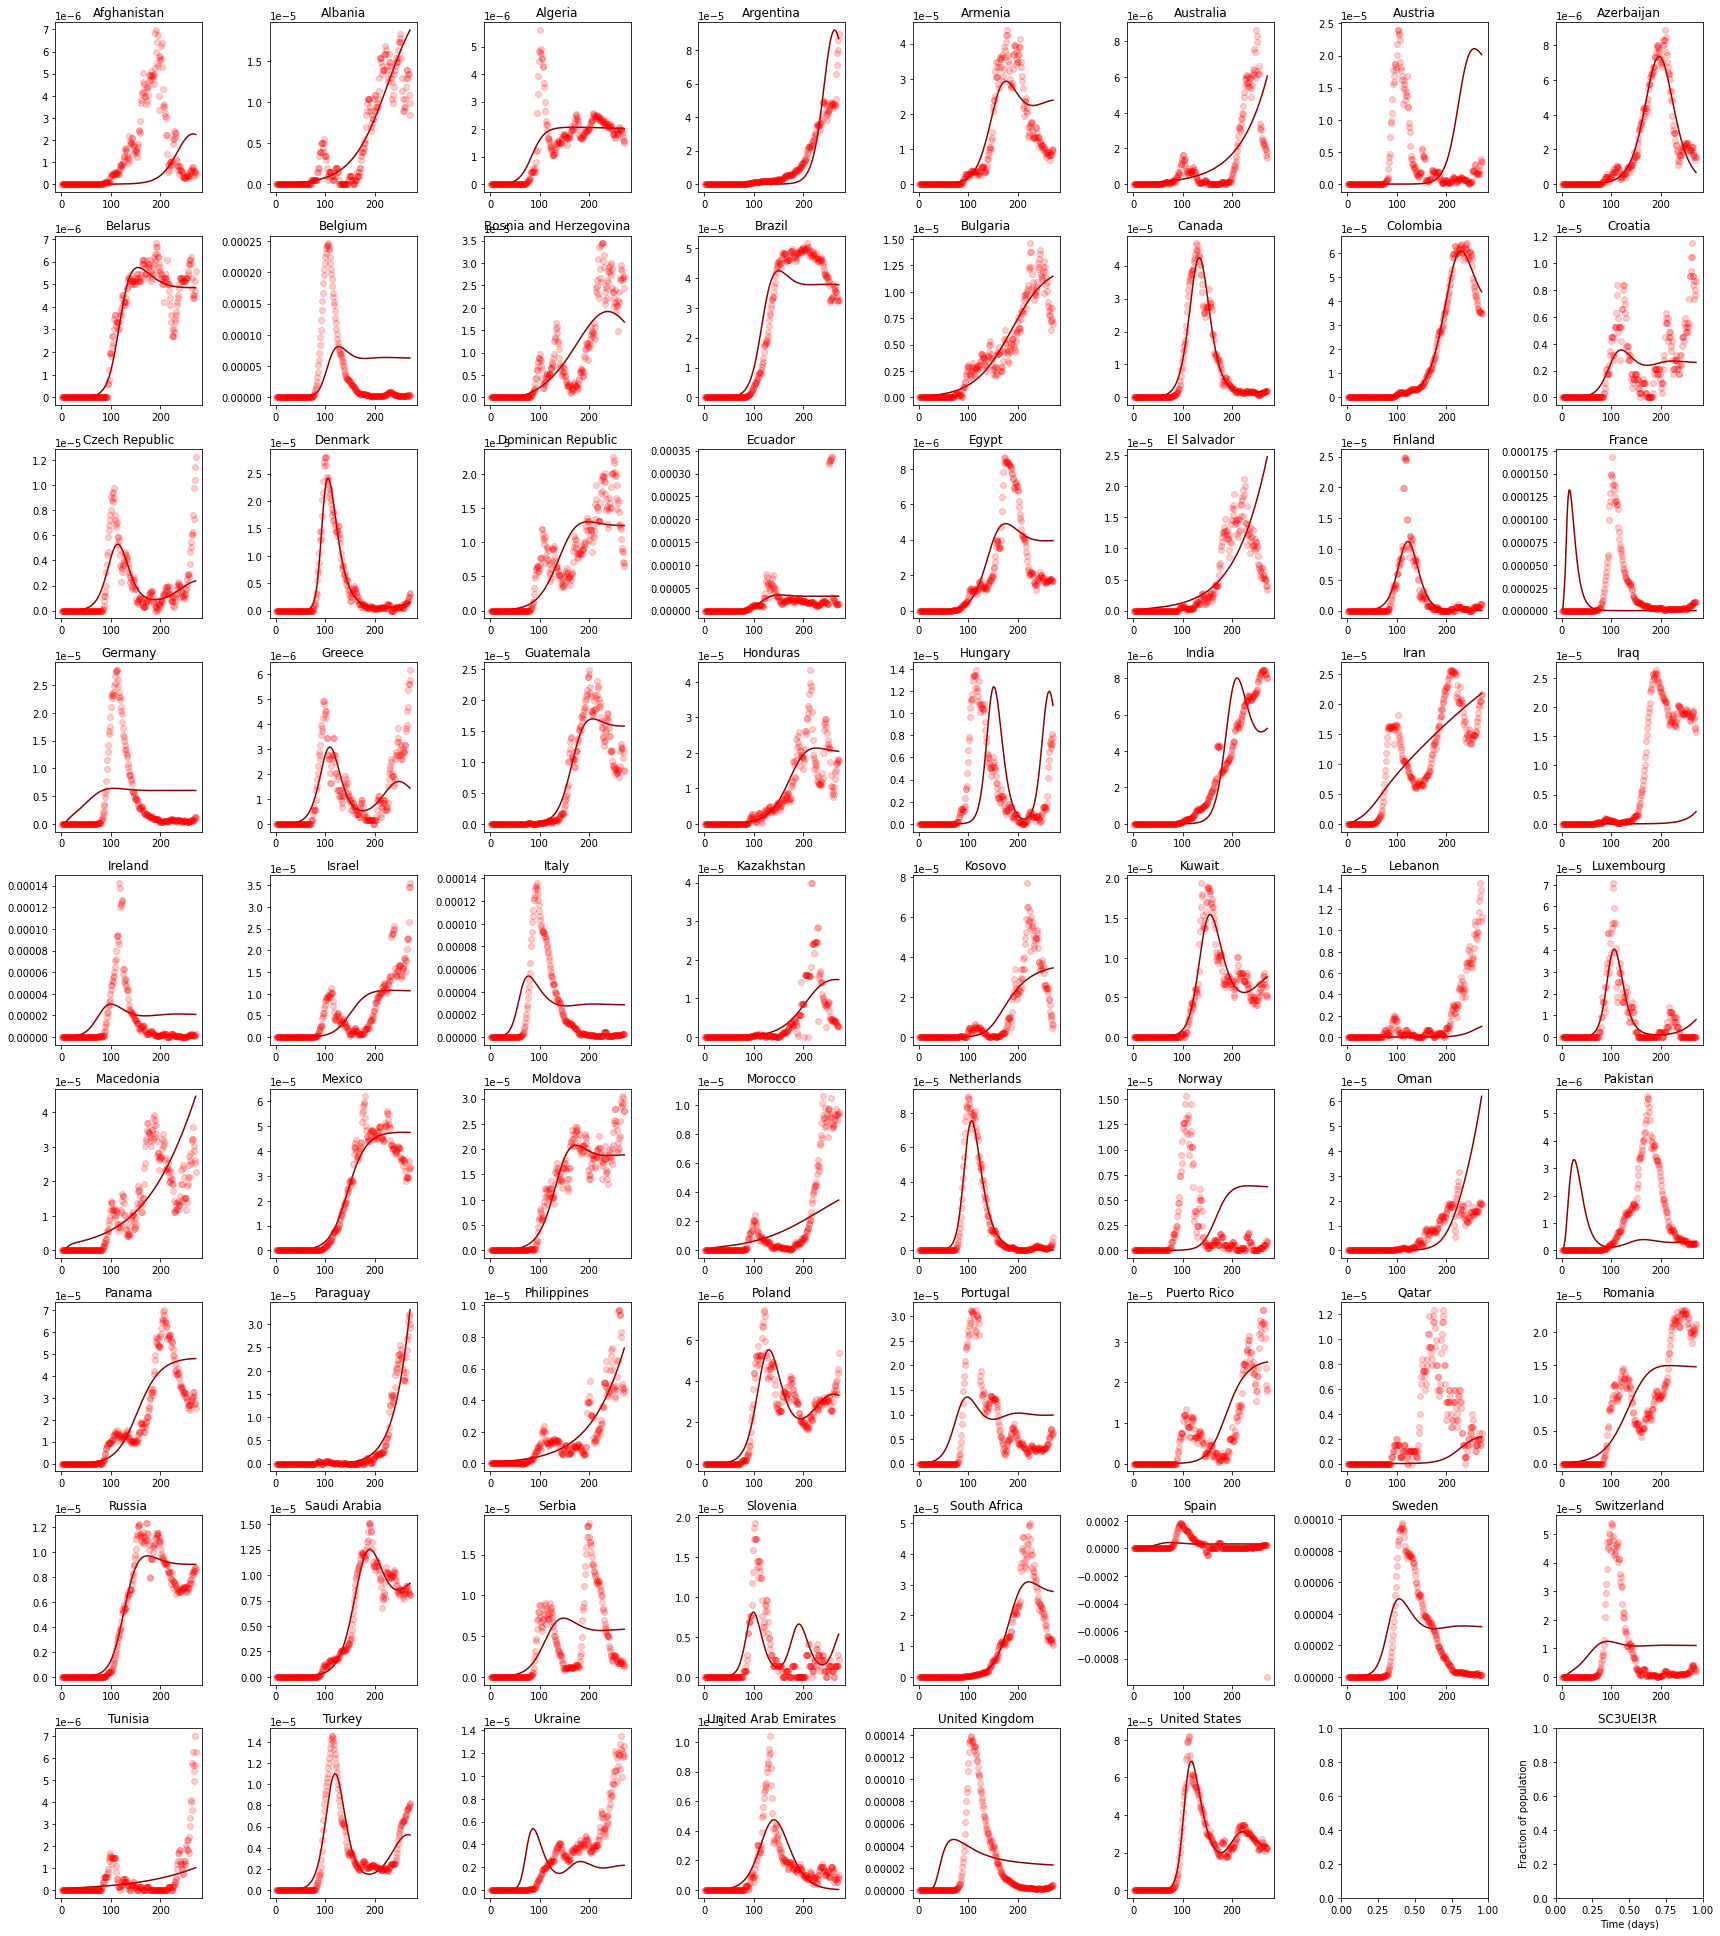

In [198]:
cnt=0
max_cols=8
max_rows=int(len(countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5000, 0.,20000),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3UEI3R',country=country,run_id="_scan") # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False)
        MyModel.solveplot(species=['deaths'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3UEI3R.pdf')
plt.show()